### Overview
Naive Bayes is a type of Machine Learning algorithm based in statistics (Bayes' Theorem) which is convenient to use in classification problems for high-dimension data. It can be used to predict sentiment analysis of text-related data, where we assume each of the input features are conditionally independent of each other (the 'prior' distribution).

In this notebook, we are going to implement a Multinomial Naive Bayes model in order to predict the sentiment of Amazon reviews for kitchen items (whether they are 'positive' or 'negative' reviews). The model is accurate to ~87% of cases sampled (it correctly classifies 'positive' as positive and 'negative' as negative 87% of our test resulst). At the end, the notebook can take an input of a new review for prediction.

In [6]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Read data into dataframe
review_data = pd.read_csv('amazon_reviews_us_Kitchen_v1_00.tsv'
                          , sep = '\t', on_bad_lines='skip')

# Rename columns we want
review_data = pd.DataFrame(data=review_data
                           , columns=['marketplace', 'customer_id',	'review_id'
                                      , 'product_id', 'product_parent', 'product_title', 'product_category'
                                      , 'star_rating',	'helpful_votes', 'total_votes',	'vine'
                                      , 'verified_purchase', 'review_headline', 'review_body', 'review_date'])

# First 10 rows
pd.set_option("display.max_columns", None)
print(review_data.head(5))

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     37000337  R3DT59XH7HXR9K  B00303FI0G       529320574   
1          US     15272914  R1LFS11BNASSU8  B00JCZKZN6       274237558   
2          US     36137863  R296RT05AG0AF6  B00JLIKA5C       544675303   
3          US     43311049  R3V37XDZ7ZCI3L  B000GBNB8G       491599489   
4          US     13763148  R14GU232NQFYX2  B00VJ5KX9S       353790155   

                                       product_title product_category  \
0                    Arthur Court Paper Towel Holder          Kitchen   
1  Olde Thompson Bavaria Glass Salt and Pepper Mi...          Kitchen   
2  Progressive International PL8 Professional Man...          Kitchen   
3                          Zyliss Jumbo Garlic Press          Kitchen   
4  1 X Premier Pizza Cutter - Stainless Steel 14"...          Kitchen   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0          5.0            0.0          0.0    N

##### Let's only keep the review text and star rating for this basic model. Later on, we could add more features if we wanted; but for now, we only want to see if we can use the review text in order to predict the 'sentiment'.

##### The 'sentiment' can be defined as 'positive' if the user gives a 4 or 5 star review, and 'negative' for a 1 or 2-star review.

In [34]:
# Keep only review body and rating

reviews = review_data[['review_body', 'star_rating']]
print('Total number of reviews:', str(len(reviews)))
print(reviews.head(2))

# ----------------------------------------------------------------------------------------------
# Create positive and negative dataframes
# ----------------------------------------------------------------------------------------------
review_data_pos = reviews.loc[review_data['star_rating'] > 3]
review_data_neg = reviews.loc[review_data['star_rating'] < 3]

# ----------------------------------------------------------------------------------------------
# Randomly select 100,000 positive reviews and 100,000 negative reviews. Combine them into one dataframe.
# ----------------------------------------------------------------------------------------------
pos_sample = review_data_pos.sample(n=100000)
neg_sample = review_data_neg.sample(n=100000)

frames = [pos_sample, neg_sample]
combined_df = pd.concat(frames)
combined_df['sentiment'] = ""

combined_df.loc[combined_df['star_rating'] == 5.0, 'sentiment'] = 1
combined_df.loc[combined_df['star_rating'] == 4.0, 'sentiment'] = 1
combined_df.loc[combined_df['star_rating'] == 2.0, 'sentiment'] = 0
combined_df.loc[combined_df['star_rating'] == 1.0, 'sentiment'] = 0

Total number of reviews: 4874890
                                         review_body  star_rating
0                Beautiful.  Looks great on counter.          5.0
1  I personally have 5 days sets and have also bo...          5.0


##### Before training the model, we'll have to clean the data and use NLP techniques to convert the text into machine-learning format, called 'tokens'. This will shorten the text, so let's see how the text looks like before preprocessing.

In [35]:
# ----------------------------------------------------------------------------------------------
# Calculate the average length of all the reviews present in the data frame, before processing.
# ----------------------------------------------------------------------------------------------
avg_word_len = 0
for text in combined_df['review_body']:
    if not(pd.isna(text)):
        avg_word_len += len(text.split())
mean_length = avg_word_len/200000
print("Average length:", mean_length)

Average length: 60.06989


In [36]:
# ----------------------------------------------------------------------------------------------
# Data Cleaning
# ----------------------------------------------------------------------------------------------
#a. Convert all the reviews to lowercase
combined_df['review_body'] = combined_df['review_body'].str.lower()
#b. Remove URLs from reviews
combined_df['review_body'] = combined_df['review_body'].str.replace(r'http\S+',r'', regex = True).str.strip()

#c. remove non-alphabetical characters
combined_df['review_body'] = combined_df['review_body'].str.replace(r',',r' ', regex = True)

combined_df['review_body'] = combined_df['review_body'].str.replace(r'[^a-zA-Z\s]',r'', regex = True)

#d. Remove extra spaces between words
combined_df['review_body'] = combined_df['review_body'].str.replace(r'\s+',r' ', regex = True)


##### In Natural Language Processing, there are a few steps to convert text data into a form that machine learning can use.

##### The first is stop word removal: getting rid of the 'fluff' in text like pronouns, prepositions, etc. and only keeping words that really signify sentiment like adjectives and nouns, in a basic explanation.

##### The next step is Lemmatization: basically converting words into their root forms or 'lemmas', like 'feet' --> 'foot', 'computers' --> 'computer', 'adds' --> 'add'

In [37]:
# ----------------------------------------------------------------------------------------------
# Data Preprocessing
# ----------------------------------------------------------------------------------------------
import nltk
from nltk.corpus import stopwords

df_pre =  combined_df.iloc[:50, :].copy(deep=True)

#Import stop word set
stop_words = set(stopwords.words('english'))
print("Before preprocessing:\n", df_pre[['review_body']].head(5))

# Remove stop words - i.e. 'the', 'it', 'they', 'I', 'is', 'are'
def stop_word_remover(x):
    return " ".join([word for word in x.split() if word.lower() not in stop_words])

combined_df['review_body'] = combined_df['review_body'].astype(str).apply(stop_word_remover)
print("\nAfter stop removal:\n\n", combined_df[['review_body']].head(5))

# whitespace_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Lemmatize words and apply to dataset
def lemmatization(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

combined_df['review_body'] = combined_df['review_body'].apply(lambda x: lemmatization(x))

print('\nAfter lemmatization:\n\n', combined_df['review_body'].head(5))

Before preprocessing:
                                                review_body
2403540  this pot is exceptionally well made and the gl...
2247073                              thanksbr its so great
3335051  this does the job just fine for cleaning my co...
3654164  i love this knife i use it for all my chopping...
3870214  while setting it up in my kitchen i was baffle...

After stop removal:

                                                review_body
2403540  pot exceptionally well made glazing perfect ei...
2247073                                     thanksbr great
3335051  job fine cleaning coffee machine brissles taug...
3654164  love knife use chopping nice quality keep shar...
3870214  setting kitchen baffled discover two full sets...

After lemmatization:

 2403540    pot exceptionally well made glazing perfect ei...
2247073                                       thanksbr great
3335051    job fine cleaning coffee machine brissles taug...
3654164    love knife use chopping nice

##### Let's calculate the new average word length of all the reviews present in the data frame. We will see that removing stop words and lemmatizing decreased the word count per review by 50% - this makes the model better able to focus on words (tokens) that provide the most signal.

In [39]:

avg_word_len = 0
for text in combined_df['review_body']:
    if not(pd.isna(text)):
        avg_word_len += len(text.split())
mean_length = avg_word_len/200000
print("Average length:", mean_length)

Average length: 30.02222


In [40]:
# ----------------------------------------------------------------------------------------------
# Partition dataset into train and test, using sklearn train_test_split
# ----------------------------------------------------------------------------------------------

X = combined_df['review_body']
y = combined_df['sentiment']
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2021)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(160000,) (160000,)
(40000,) (40000,)


##### Term frequency Inverse document frequency (TFIDF) is a statistical formula to convert text documents into vectors based on the relevancy of the word. Basically, it finds out which are the most and least relevant words that frequently occur in the data, and assigns a fractional number based on the relative importance.

In [41]:
# ----------------------------------------------------------------------------------------------
# Extract the tfidf features from train and test dataset using sklearn TfidfVectorizer.
# ----------------------------------------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train) # Fit_transform the train data
X_test = vectorizer.transform(X_test)   # transform test data

##### Finally, let's train a basic model for Multinomial Naive Bayes. 'Multinomial' refers to the nature of the input data, where the inputs are either integers (discrete # of how many times each token/word was found to occur in the training data) or TFIDF, which is a fractional value. 

In [60]:
# ----------------------------------------------------------------------------------------------
# Train multinomial naive Bayes, and evaluate model performance on training set
# ----------------------------------------------------------------------------------------------
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate
naive_bayes = MultinomialNB()

# Fit model
naive_bayes.fit(X_train, y_train)

# Predict on train data
y_pred_train = naive_bayes.predict(X_train)

# Train accuracy score:
accuracy = accuracy_score(y_train, y_pred_train)
precision =  precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train) 
f1 = f1_score(y_train, y_pred_train)
print("Train accuracy, precision, recall, f1: %f, %f, %f, %f" % (100*accuracy_train, 100*precision, 100*recall, 100*f1)) # 89.36%


Train accuracy, precision, recall, f1: 89.365625, 90.259649, 88.291605, 89.264781


##### Let's also compare training metrics to test, and see how well the model performs in each scenario. Note that Naive Bayes has no hyperparameters to tune due to its 'Naive' statistical underpinnings. Ideally the train and test metrics will be close to each other, to indicate lack of overfitting.

In [64]:
# Predict on test data
y_pred_test = naive_bayes.predict(X_test)

#accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test =  precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test) 
f1_test = f1_score(y_test, y_pred_test)
print("Test accuracy, precision, recall, f1: %f, %f, %f, %f" % (100*accuracy_test, 100*precision_test, 100*recall_test, 100*f1_test)) # 89.36%


Test accuracy, precision, recall, f1: 87.330000, 88.296442, 85.888922, 87.076044


##### Since we have a binary classification of 'positive' or 'negative', we can visualize the total number of times the model was correct or incorrect in its predictions with the plot below.

<Axes: title={'center': 'Confusion Matrix for NB Predictions'}>

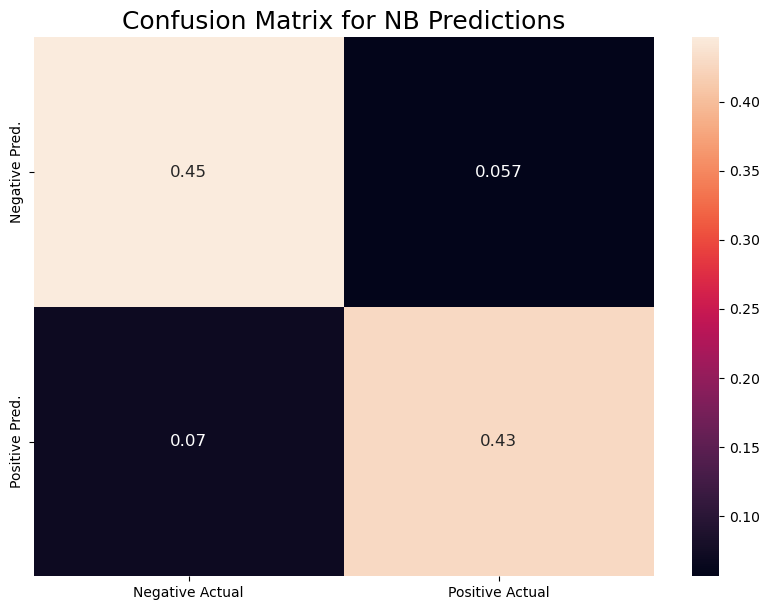

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_test)
cm = cm/40000
df_cm = pd.DataFrame(cm, index=['Negative Pred.', 'Positive Pred.'], columns=['Negative Actual', 'Positive Actual'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix for NB Predictions', fontsize=18)
sns.heatmap(df_cm, annot=True, annot_kws={"size":12})

##### Finally, we can input any given sample review, and see what the model will predict for its sentiment.

In [85]:
sample = str(input('Which review would you like to predict?: '))
# The sample input here was, I would recommend it, I use it every day!
sample = lemmatization(sample)
sample = vectorizer.transform([sample])
pred = naive_bayes.predict(sample)
if pred == ['0']:
    print('Predicted sentiment: Negative')
else:
    print('Predicted sentiment: Positive')

Predicted sentiment: Positive
